In [299]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import scale
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, r2_score, f1_score, confusion_matrix, roc_auc_score, matthews_corrcoef, log_loss
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates

In [397]:
start_date = datetime.strptime('2018-07-02', '%Y-%m-%d')
end_date = datetime.strptime('2023-07-01', '%Y-%m-%d')

dir_list = [item for item in os.listdir(os.getcwd()) if os.path.isdir(item)]
# dir_list = [item for item in dir_list if item.split('_')[1] == '63']

###
dir_list = ['50elefin_63']
###

In [398]:
def std(df):
    scaler = StandardScaler()
    df_copy = df.copy()  # 複製DataFrame
    numeric_columns = df_copy.select_dtypes(include=['float64', 'int64']).columns
    df_copy[numeric_columns] = scaler.fit_transform(df_copy[numeric_columns])
    return df_copy

In [391]:
BCI = pd.read_csv('../00 Raw Data/Indicator.csv', index_col=0, parse_dates=True).rename_axis(None, axis=0)
BCI.index = (BCI.index + pd.offsets.MonthBegin(1)) + pd.offsets.MonthEnd(0)
BCI.columns = ['BCI']
BCI_std = std(BCI)

BCI_Real = pd.read_csv('../00 Raw Data/Indicator.csv', index_col=0, parse_dates=True).rename_axis(None, axis=0)
BCI_Real.index = BCI_Real.index + pd.offsets.MonthEnd(0)
BCI_Real.columns = ['BCI']
BCI_Real_std = std(BCI_Real)

LEI = pd.read_csv('../00 Raw Data/Leading_Indicator.csv', index_col=0, parse_dates=True).rename_axis(None, axis=0)
LEI.index = (LEI.index + pd.offsets.MonthBegin(1)) + pd.offsets.MonthEnd(0)
LEI.columns = ['LEI']
LEI_std = std(LEI)

COI = pd.read_csv('../00 Raw Data/Coincident_Indicator.csv', index_col=0, parse_dates=True).rename_axis(None, axis=0)
COI.index = (COI.index + pd.offsets.MonthBegin(1)) + pd.offsets.MonthEnd(0)
COI.columns = ['COI']
COI_std = std(COI)

LAI = pd.read_csv('../00 Raw Data/Lagging_Indicator.csv', index_col=0, parse_dates=True).rename_axis(None, axis=0)
LAI.index = (LAI.index + pd.offsets.MonthBegin(1)) + pd.offsets.MonthEnd(0)
LAI.columns = ['LAI']
LAI_std = std(LAI)

macro = pd.read_csv('../00 Raw Data/macro_return.csv', index_col=0, parse_dates=True).rename_axis(None, axis=0)
macro_std = std(macro)

SVI = pd.read_csv('../00 Raw Data/SVI.csv', index_col=0, parse_dates=True).rename_axis(None, axis=0)
SVI_std = std(SVI)

VIXTWN = pd.read_csv('../00 Raw Data/VIXTWN.csv', index_col=0, parse_dates=True).rename_axis(None, axis=0)
VIXTWN_std = std(VIXTWN)

In [392]:
def score_to_recession(score):
    if 9 <= score <= 22:
        return 1
    else:
        return 0

def bm_model(X, y):
    n = len(X)
    train_size = int(n * 0.7)

    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    lr_model = LogisticRegression(C=10, max_iter=10000, random_state=42, multi_class='ovr')
    xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)

    lr_model.fit(X_train, y_train)
    y_pred_train_lr = lr_model.predict(X_train)
    y_pred_test_lr = lr_model.predict(X_test)
    y_pred_proba_train_lr = lr_model.predict_proba(X_train)[:, 1]
    y_pred_proba_test_lr = lr_model.predict_proba(X_test)[:, 1]

    predict_proba_train_lr = pd.DataFrame(y_pred_proba_train_lr)
    predict_proba_test_lr = pd.DataFrame(y_pred_proba_test_lr)
    predict_proba_lr = pd.concat([predict_proba_train_lr, predict_proba_test_lr], axis=0)
    predict_proba_lr.index = X.index

    xgb_model.fit(X_train, y_train)
    y_pred_train_xgb = xgb_model.predict(X_train)
    y_pred_test_xgb = xgb_model.predict(X_test)
    y_pred_proba_train_xgb = xgb_model.predict_proba(X_train)[:, 1]
    y_pred_proba_test_xgb = xgb_model.predict_proba(X_test)[:, 1]

    predict_proba_train_xgb = pd.DataFrame(y_pred_proba_train_xgb)
    predict_proba_test_xgb = pd.DataFrame(y_pred_proba_test_xgb)
    predict_proba_xgb = pd.concat([predict_proba_train_xgb, predict_proba_test_xgb], axis=0)
    predict_proba_xgb.index = X.index

    return y_pred_train_lr, y_pred_test_lr, y_pred_proba_train_lr, y_pred_proba_test_lr, y_pred_train_xgb, y_pred_test_xgb, y_pred_proba_train_xgb, y_pred_proba_test_xgb


def performance(X, y, data_choose, BCI_Real_monthly):
    n = len(X)
    train_size = int(n * 0.7)

    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    models = {
        "Logistic Regression": LogisticRegression(C=10, max_iter=10000, random_state=42, multi_class='ovr'),
        "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42)
    }

    model_performance = {}

    for name, model in models.items():
        print(data_choose, ',', name)
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]

        print('In-sample Accuracy   =', f'{accuracy_score(y_train, y_pred_train):.4f}')
        print('In-sample Precision  =', f'{precision_score(y_train, y_pred_train):.4f}')
        print('In-sample Recall     =', f'{recall_score(y_train, y_pred_train):.4f}')
        print('In-sample F1 Score   =', f'{f1_score(y_train, y_pred_train):.4f}')
        print('In-sample AUC-ROC    =', f'{roc_auc_score(y_train, y_pred_proba_train):.4f}')
        print('Out-sample Accuracy  =', f'{accuracy_score(y_test, y_pred_test):.4f}')
        print('Out-sample Precision =', f'{precision_score(y_test, y_pred_test):.4f}')
        print('Out-sample Recall    =', f'{recall_score(y_test, y_pred_test):.4f}')
        print('Out-sample F1 Score  =', f'{f1_score(y_test, y_pred_test):.4f}')
        print('Out-sample AUC-ROC   =', f'{roc_auc_score(y_test, y_pred_proba_test):.4f}')
        print()

        predict_proba_train = pd.DataFrame(y_pred_proba_train)
        predict_proba_test = pd.DataFrame(y_pred_proba_test)
        predict_proba = pd.concat([predict_proba_train, predict_proba_test], axis=0)
        predict_proba.index = X.index

        plt.figure(figsize=(15,6))
        plt.hlines(y = 1.1, xmin=predict_proba.index[0] - pd.DateOffset(days=15), xmax=predict_proba.index[len(predict_proba_train)] - pd.DateOffset(days=15), color='salmon', linestyle='-', linewidth=10)
        plt.hlines(y = -0.1, xmin=predict_proba.index[0] - pd.DateOffset(days=15), xmax=predict_proba.index[len(predict_proba_train)] - pd.DateOffset(days=15), color='salmon', linestyle='-', linewidth=10)
        plt.hlines(y = 1.1, xmin=predict_proba.index[len(predict_proba_train)]- pd.DateOffset(days=15), xmax= predict_proba.index[-1] + pd.DateOffset(days=15), color='royalblue', linestyle='-', linewidth=10)
        plt.hlines(y = -0.1, xmin=predict_proba.index[len(predict_proba_train)]- pd.DateOffset(days=15), xmax= predict_proba.index[-1] + pd.DateOffset(days=15), color='royalblue', linestyle='-', linewidth=10)
        # plt.plot(BCI_Real_monthly['Recession'], linewidth=2, color='k', alpha=0.7)
        plt.plot(predict_proba, linewidth=3, color='royalblue', alpha=0.3)

        start_index = int(len(predict_proba) * 0.7)
        for i in range(len(predict_proba)):
            if BCI_Real_monthly['Recession'].iloc[i] == 1 and predict_proba.values[i] < 0.5:
                plt.scatter(predict_proba.index[i], predict_proba.values[i], color='darkgreen', marker='x', s=80, lw=2.5, alpha=1)
            elif BCI_Real_monthly['Recession'].iloc[i] == 0 and predict_proba.values[i] > 0.5:
                plt.scatter(predict_proba.index[i], predict_proba.values[i], color='darkgreen', marker='^', s=60, lw=1, alpha=1)
            else:
                plt.scatter(predict_proba.index[i], predict_proba.values[i], color='darkblue', alpha=1)
            if i >= start_index:
                date_num = mdates.date2num(predict_proba.index[i])
                offset_x = 10  # 以天為單位調整此值
                plt.text(date_num + offset_x, predict_proba.values[i] - 0.02, str(i - start_index + 1), 
                        color='darkred', fontsize=10, fontweight='heavy', ha='left', va='top')
        plt.scatter(BCI_Real_monthly['Recession'].index, BCI_Real_monthly['Recession'], color='darkred', marker='s', alpha=1)
        plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.4)
        plt.ylim(-0.1, 1.1)
        plt.savefig(f'{folder}/Result_{data_choose}_{name}.png', dpi=144, transparent=True)
        plt.show()

        if name == 'Logistic Regression':
            z = np.dot(X, model.coef_.T) + model.intercept_
            y_pred_combined = np.concatenate([y_pred_train, y_pred_test])
            y_pred_combined = pd.DataFrame(y_pred_combined)
            y_pred_combined.index = y.index
            y_pred_combined.columns = ['Recession']

            z = pd.DataFrame(z)
            z.columns = ['z']
            z.index = X.index
            z = pd.concat([z, y_pred_combined], axis=1)

            def sigmoid(z):
                return 1 / (1 + np.exp(-z))
            z['sigmoid'] = sigmoid(z['z'])

            # plt.figure(figsize=(15, 5))
            # plt.scatter(z['z'], z['Recession'], label='Real')
            # plt.plot(z['z'], z['sigmoid'], 'ro', label='Sigmoid prob')
            # plt.xlabel(r'$\theta^T$$X$')
            # plt.xlim(-6.5, 6.5)
            # plt.savefig(f'{folder}/Sigmoid_{data_choose}.png', dpi=144, transparent=True)
            # plt.show()

            z_test = np.dot(X_test, model.coef_.T) + model.intercept_
            y_pred_combined = np.concatenate([y_pred_test])
            y_pred_combined = pd.DataFrame(y_pred_combined)
            y_pred_combined.index = y_test.index
            y_pred_combined.columns = ['Recession']

            # print(z)
            z_test = pd.DataFrame(z_test)
            z_test.columns = ['z']
            z_test.index = X_test.index
            z_test = pd.concat([z_test, y_pred_combined], axis=1)
            # 假設 test_z 是您提供的 DataFrame
            # 這裡 z 是模型的線性組合輸出，Recession 是實際的類別標籤

            # 定義 sigmoid 函數
            def sigmoid(z):
                return 1 / (1 + np.exp(-z))

            # 計算 sigmoid 函數的值
            z_test['sigmoid'] = sigmoid(z_test['z'])

            # 繪製圖形
            # plt.figure(figsize=(15, 5))
            # plt.scatter(z_test['z'], z_test['Recession'], label='Real')
            # plt.plot(z_test['z'], z_test['sigmoid'], 'ro', label='Sigmoid prob')
            # for i in range(len(z_test)):
            #     plt.text(z_test['z'][i], z_test['Recession'][i], z_test.index[i].strftime('%y/%m'), fontsize=9, ha='left', va='bottom')
            # # 添加額外的圖形參數，如標籤和標題
            # plt.xlabel(r'$\theta^T$$X$')
            # plt.xlim(-1.5, 4)
            # plt.savefig(f'{folder}/Sigmoid_test_{data_choose}.png', dpi=144, transparent=True)
            # plt.show()
        
            plt.figure(figsize=(6,6))
            for i in range(len(y_pred_proba_test)):
                if BCI_Real_monthly['Recession'].iloc[len(BCI_Real_monthly) - len(y_pred_proba_test) + i] == 1 and y_pred_proba_test[i] < 0.5:
                    plt.scatter(y_pred_proba_test_lr[i], y_pred_proba_test[i], color='darkgreen', marker='x', s=80, lw=2.5, alpha=1)
                elif BCI_Real_monthly['Recession'].iloc[len(BCI_Real_monthly) - len(y_pred_proba_test) + i] == 0 and y_pred_proba_test[i] > 0.5:
                    plt.scatter(y_pred_proba_test_lr[i], y_pred_proba_test[i], color='darkgreen', marker='^', s=60, lw=1, alpha=1)
                else:
                    plt.scatter(y_pred_proba_test_lr[i], y_pred_proba_test[i], color='royalblue', alpha=1)
            for i, (x, y) in enumerate(zip(y_pred_proba_test_lr, y_pred_proba_test)):
                plt.text(x+0.01, y-0.01, str(i + 1), color='darkred', fontweight='heavy', fontsize=10, ha='left', va='top')
            plt.xlabel(r'$P(Y_t=1|X_t$ $is$ $Benchmark$)$')
            plt.ylabel(r'$P(Y_t=1|X_t$ $is$ ' + f'{data_choose}' + r'$)$')
            plt.plot([0, 1], [0, 1], 'k--', alpha=0.4)
            plt.xlim(0, 1)
            plt.ylim(0, 1)
            plt.savefig(f'{folder}/Scatter plot_{data_choose}_{name}', dpi=144, transparent=True)
            plt.show()
        
        if name == 'XGBoost':
            plt.figure(figsize=(6,6))
            for i in range(len(y_pred_proba_test)):
                if BCI_Real_monthly['Recession'].iloc[len(BCI_Real_monthly) - len(y_pred_proba_test) + i] == 1 and y_pred_proba_test[i] < 0.5:
                    plt.scatter(y_pred_proba_test_xgb[i], y_pred_proba_test[i], color='darkgreen', marker='x', s=80, lw=2.5, alpha=1)
                elif BCI_Real_monthly['Recession'].iloc[len(BCI_Real_monthly) - len(y_pred_proba_test) + i] == 0 and y_pred_proba_test[i] > 0.5:
                    plt.scatter(y_pred_proba_test_xgb[i], y_pred_proba_test[i], color='darkgreen', marker='^', s=60, lw=1, alpha=1)
                else:
                    plt.scatter(y_pred_proba_test_xgb[i], y_pred_proba_test[i], color='royalblue', alpha=1)
            for i, (x, y) in enumerate(zip(y_pred_proba_test_xgb, y_pred_proba_test)):
                plt.text(x+0.01, y-0.01, str(i + 1), color='darkred', fontweight='heavy', fontsize=10, ha='left', va='top')
            plt.xlabel(r'$P(Y_t=1|X_t$ $is$ $Benchmark)$')
            plt.ylabel(r'$P(Y_t=1|X_t$ $is$ ' + f'{data_choose}' + r'$)$')
            plt.plot([0, 1], [0, 1], 'k--', alpha=0.4)
            plt.xlim(0, 1)
            plt.ylim(0, 1)
            plt.savefig(f'{folder}/Scatter plot_{data_choose}_{name}', dpi=144, transparent=True)
            plt.show()



    print('-----')
    print()
    return y_pred_train, y_pred_test, y_pred_proba_train, y_pred_proba_test

In [453]:
###############################

def score_to_recession(score):
    if 9 <= score <= 22:
        return 1
    else:
        return 0

def bm_model(X, y):
    n = len(X)
    train_size = int(n * 0.7)

    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    lr_model = LogisticRegression(C=10, max_iter=10000, random_state=42, multi_class='ovr')
    xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)

    lr_model.fit(X_train, y_train)
    y_pred_train_lr = lr_model.predict(X_train)
    y_pred_test_lr = lr_model.predict(X_test)
    y_pred_proba_train_lr = lr_model.predict_proba(X_train)[:, 1]
    y_pred_proba_test_lr = lr_model.predict_proba(X_test)[:, 1]

    predict_proba_train_lr = pd.DataFrame(y_pred_proba_train_lr)
    predict_proba_test_lr = pd.DataFrame(y_pred_proba_test_lr)
    predict_proba_lr = pd.concat([predict_proba_train_lr, predict_proba_test_lr], axis=0)
    predict_proba_lr.index = X.index

    xgb_model.fit(X_train, y_train)
    y_pred_train_xgb = xgb_model.predict(X_train)
    y_pred_test_xgb = xgb_model.predict(X_test)
    y_pred_proba_train_xgb = xgb_model.predict_proba(X_train)[:, 1]
    y_pred_proba_test_xgb = xgb_model.predict_proba(X_test)[:, 1]

    predict_proba_train_xgb = pd.DataFrame(y_pred_proba_train_xgb)
    predict_proba_test_xgb = pd.DataFrame(y_pred_proba_test_xgb)
    predict_proba_xgb = pd.concat([predict_proba_train_xgb, predict_proba_test_xgb], axis=0)
    predict_proba_xgb.index = X.index

    return y_pred_train_lr, y_pred_test_lr, y_pred_proba_train_lr, y_pred_proba_test_lr, y_pred_train_xgb, y_pred_test_xgb, y_pred_proba_train_xgb, y_pred_proba_test_xgb


def performance(X, y, data_choose, BCI_Real_monthly):
    n = len(X)
    train_size = int(n * 0.7)

    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    models = {
        "Logistic Regression": LogisticRegression(C=10, max_iter=10000, random_state=42, multi_class='ovr'),
        "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42)
    }

    model_performance = {}

    for name, model in models.items():
        print(data_choose, ',', name)
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]
        print('AUC =', f'{roc_auc_score(y_test, y_pred_proba_test):.4f}')
        print()
        cm = confusion_matrix(y_test, y_pred_test)

        predict_proba_train = pd.DataFrame(y_pred_proba_train)
        predict_proba_test = pd.DataFrame(y_pred_proba_test)
        predict_proba = pd.concat([predict_proba_train, predict_proba_test], axis=0)
        predict_proba.index = X.index

        plt.figure(figsize=(15,6))
        plt.hlines(y = 1.1, xmin=predict_proba.index[0] - pd.DateOffset(days=15), xmax=predict_proba.index[len(predict_proba_train)] - pd.DateOffset(days=15), color='salmon', linestyle='-', linewidth=10)
        plt.hlines(y = -0.1, xmin=predict_proba.index[0] - pd.DateOffset(days=15), xmax=predict_proba.index[len(predict_proba_train)] - pd.DateOffset(days=15), color='salmon', linestyle='-', linewidth=10)
        plt.hlines(y = 1.1, xmin=predict_proba.index[len(predict_proba_train)]- pd.DateOffset(days=15), xmax= predict_proba.index[-1] + pd.DateOffset(days=15), color='royalblue', linestyle='-', linewidth=10)
        plt.hlines(y = -0.1, xmin=predict_proba.index[len(predict_proba_train)]- pd.DateOffset(days=15), xmax= predict_proba.index[-1] + pd.DateOffset(days=15), color='royalblue', linestyle='-', linewidth=10)
        # plt.plot(BCI_Real_monthly['Recession'], linewidth=2, color='k', alpha=0.7)
        plt.plot(predict_proba, linewidth=3, color='royalblue', alpha=0.3)

        start_index = int(len(predict_proba) * 0.7)
        for i in range(len(predict_proba)):
            if BCI_Real_monthly['Recession'].iloc[i] == 1 and predict_proba.values[i] < 0.5:
                plt.scatter(predict_proba.index[i], predict_proba.values[i], color='darkgreen', marker='x', s=80, lw=2.5, alpha=1)
            elif BCI_Real_monthly['Recession'].iloc[i] == 0 and predict_proba.values[i] > 0.5:
                plt.scatter(predict_proba.index[i], predict_proba.values[i], color='darkgreen', marker='^', s=60, lw=1, alpha=1)
            else:
                plt.scatter(predict_proba.index[i], predict_proba.values[i], color='darkblue', alpha=1)
            if i >= start_index:
                date_num = mdates.date2num(predict_proba.index[i])
                offset_x = 10  # 以天為單位調整此值
                plt.text(date_num + offset_x, predict_proba.values[i] - 0.02, str(i - start_index + 1), 
                        color='darkred', fontsize=10, fontweight='heavy', ha='left', va='top')
        plt.scatter(BCI_Real_monthly['Recession'].index, BCI_Real_monthly['Recession'], color='darkred', marker='s', alpha=1)
        plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.4)
        plt.ylim(-0.1, 1.1)
        plt.yticks(fontsize=14, fontweight='heavy')
        plt.xticks(fontsize=14, fontweight='heavy')
        plt.savefig(f'{folder}/Result_{data_choose}_{name}.png', dpi=144, transparent=True)
        plt.show()
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.show()

        if name == 'Logistic Regression':
            z = np.dot(X, model.coef_.T) + model.intercept_
            y_pred_combined = np.concatenate([y_pred_train, y_pred_test])
            y_pred_combined = pd.DataFrame(y_pred_combined)
            y_pred_combined.index = y.index
            y_pred_combined.columns = ['Recession']

            z = pd.DataFrame(z)
            z.columns = ['z']
            z.index = X.index
            z = pd.concat([z, y_pred_combined], axis=1)

            def sigmoid(z):
                return 1 / (1 + np.exp(-z))
            z['sigmoid'] = sigmoid(z['z'])

            # plt.figure(figsize=(15, 5))
            # plt.scatter(z['z'], z['Recession'], label='Real')
            # plt.plot(z['z'], z['sigmoid'], 'ro', label='Sigmoid prob')
            # plt.xlabel(r'$\theta^T$$X$')
            # plt.xlim(-6.5, 6.5)
            # plt.savefig(f'{folder}/Sigmoid_{data_choose}.png', dpi=144, transparent=True)
            # plt.show()

            z_test = np.dot(X_test, model.coef_.T) + model.intercept_
            y_pred_combined = np.concatenate([y_pred_test])
            y_pred_combined = pd.DataFrame(y_pred_combined)
            y_pred_combined.index = y_test.index
            y_pred_combined.columns = ['Recession']

            # print(z)
            z_test = pd.DataFrame(z_test)
            z_test.columns = ['z']
            z_test.index = X_test.index
            z_test = pd.concat([z_test, y_pred_combined], axis=1)
            # 假設 test_z 是您提供的 DataFrame
            # 這裡 z 是模型的線性組合輸出，Recession 是實際的類別標籤

            # 定義 sigmoid 函數
            def sigmoid(z):
                return 1 / (1 + np.exp(-z))

            # 計算 sigmoid 函數的值
            z_test['sigmoid'] = sigmoid(z_test['z'])

            # 繪製圖形
            # plt.figure(figsize=(15, 5))
            # plt.scatter(z_test['z'], z_test['Recession'], label='Real')
            # plt.plot(z_test['z'], z_test['sigmoid'], 'ro', label='Sigmoid prob')
            # for i in range(len(z_test)):
            #     plt.text(z_test['z'][i], z_test['Recession'][i], z_test.index[i].strftime('%y/%m'), fontsize=9, ha='left', va='bottom')
            # # 添加額外的圖形參數，如標籤和標題
            # plt.xlabel(r'$\theta^T$$X$')
            # plt.xlim(-1.5, 4)
            # plt.savefig(f'{folder}/Sigmoid_test_{data_choose}.png', dpi=144, transparent=True)
            # plt.show()
        
            # plt.figure(figsize=(6,6))
            # for i in range(len(y_pred_proba_test)):
            #     if BCI_Real_monthly['Recession'].iloc[len(BCI_Real_monthly) - len(y_pred_proba_test) + i] == 1 and y_pred_proba_test[i] < 0.5:
            #         plt.scatter(y_pred_proba_test_lr[i], y_pred_proba_test[i], color='darkgreen', marker='x', s=80, lw=2.5, alpha=1)
            #     elif BCI_Real_monthly['Recession'].iloc[len(BCI_Real_monthly) - len(y_pred_proba_test) + i] == 0 and y_pred_proba_test[i] > 0.5:
            #         plt.scatter(y_pred_proba_test_lr[i], y_pred_proba_test[i], color='darkgreen', marker='^', s=60, lw=1, alpha=1)
            #     else:
            #         plt.scatter(y_pred_proba_test_lr[i], y_pred_proba_test[i], color='royalblue', alpha=1)
            # for i, (x, y) in enumerate(zip(y_pred_proba_test_lr, y_pred_proba_test)):
            #     plt.text(x+0.01, y-0.01, str(i + 1), color='darkred', fontweight='heavy', fontsize=10, ha='left', va='top')
            # plt.xlabel(r'$P(Y_t=1|X_t$ $is$ $Benchmark$)$')
            # plt.ylabel(r'$P(Y_t=1|X_t$ $is$ ' + f'{data_choose}' + r'$)$')
            # plt.plot([0, 1], [0, 1], 'k--', alpha=0.4)
            # plt.xlim(0, 1)
            # plt.ylim(0, 1)
            # plt.savefig(f'{folder}/Scatter plot_{data_choose}_{name}', dpi=144, transparent=True)
            # plt.show()
        
        # if name == 'XGBoost':
        #     plt.figure(figsize=(6,6))
        #     for i in range(len(y_pred_proba_test)):
        #         if BCI_Real_monthly['Recession'].iloc[len(BCI_Real_monthly) - len(y_pred_proba_test) + i] == 1 and y_pred_proba_test[i] < 0.5:
        #             plt.scatter(y_pred_proba_test_xgb[i], y_pred_proba_test[i], color='darkgreen', marker='x', s=80, lw=2.5, alpha=1)
        #         elif BCI_Real_monthly['Recession'].iloc[len(BCI_Real_monthly) - len(y_pred_proba_test) + i] == 0 and y_pred_proba_test[i] > 0.5:
        #             plt.scatter(y_pred_proba_test_xgb[i], y_pred_proba_test[i], color='darkgreen', marker='^', s=60, lw=1, alpha=1)
        #         else:
        #             plt.scatter(y_pred_proba_test_xgb[i], y_pred_proba_test[i], color='royalblue', alpha=1)
        #     for i, (x, y) in enumerate(zip(y_pred_proba_test_xgb, y_pred_proba_test)):
        #         plt.text(x+0.01, y-0.01, str(i + 1), color='darkred', fontweight='heavy', fontsize=10, ha='left', va='top')
        #     plt.xlabel(r'$P(Y_t=1|X_t$ $is$ $Benchmark)$')
        #     plt.ylabel(r'$P(Y_t=1|X_t$ $is$ ' + f'{data_choose}' + r'$)$')
        #     plt.plot([0, 1], [0, 1], 'k--', alpha=0.4)
        #     plt.xlim(0, 1)
        #     plt.ylim(0, 1)
        #     plt.savefig(f'{folder}/Scatter plot_{data_choose}_{name}', dpi=144, transparent=True)
        #     plt.show()



    print('-----')
    print()
    return y_pred_train, y_pred_test, y_pred_proba_train, y_pred_proba_test

50elefin_63

-----

F , Logistic Regression
AUC = 0.7714



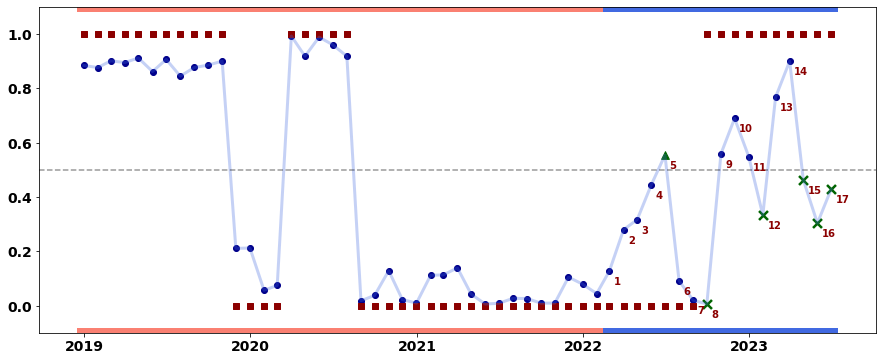

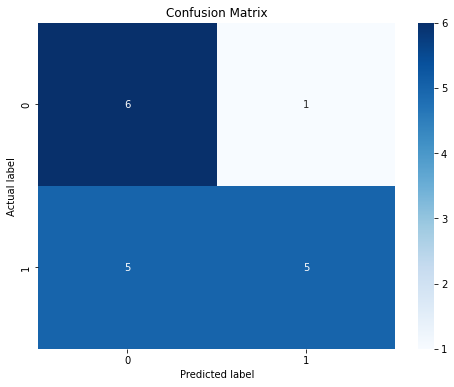

F , XGBoost
AUC = 0.6000



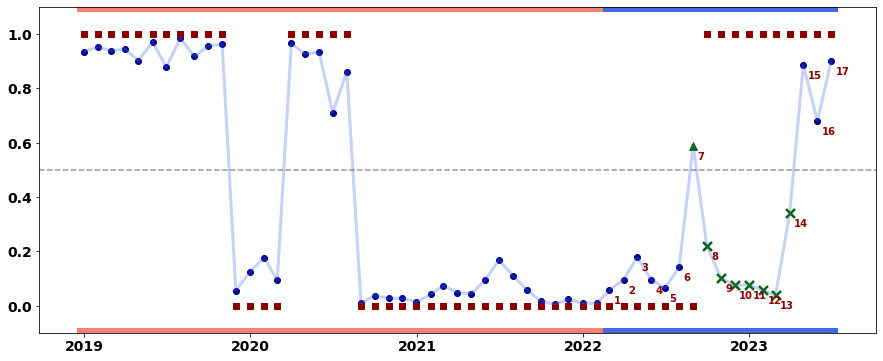

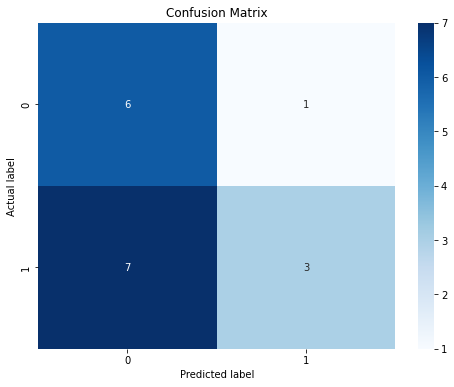

-----

-----

V , Logistic Regression
AUC = 0.2714



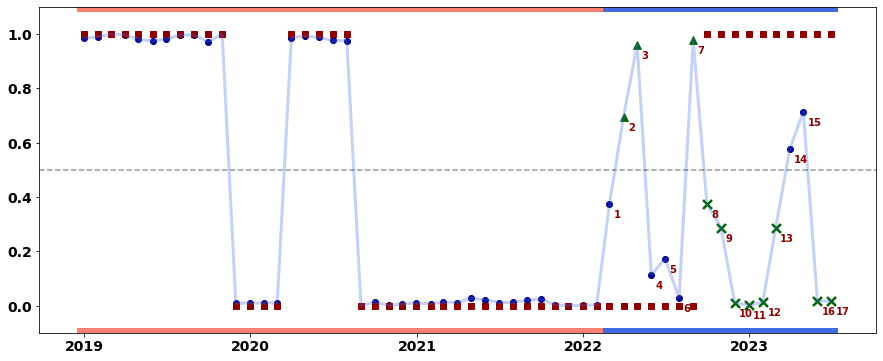

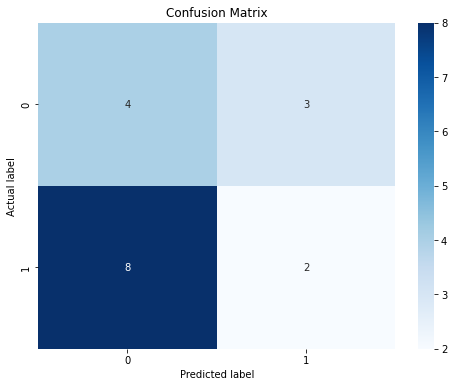

V , XGBoost
AUC = 0.3857



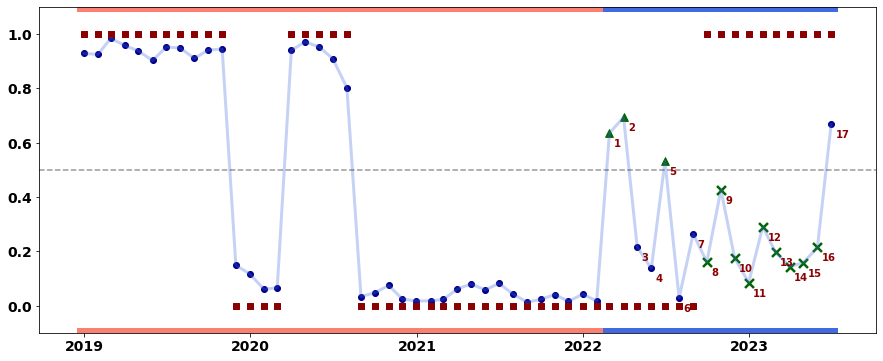

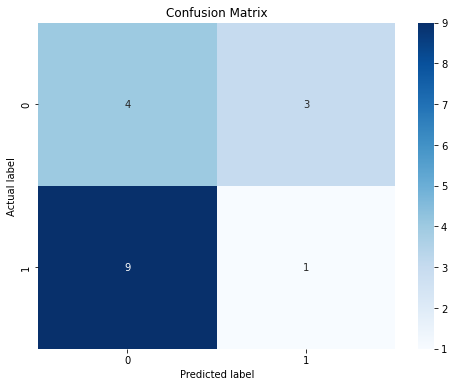

-----

-----

F+V , Logistic Regression
AUC = 0.3000



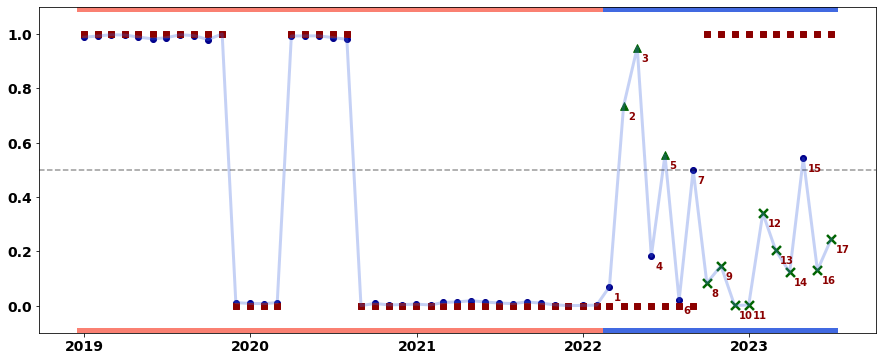

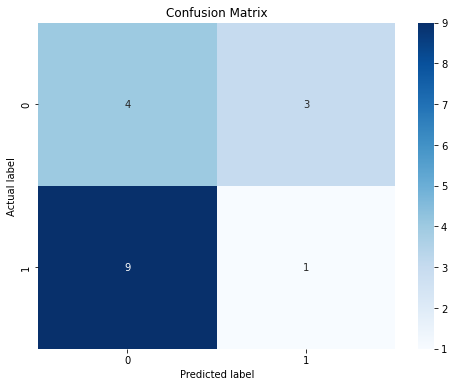

F+V , XGBoost
AUC = 0.5143



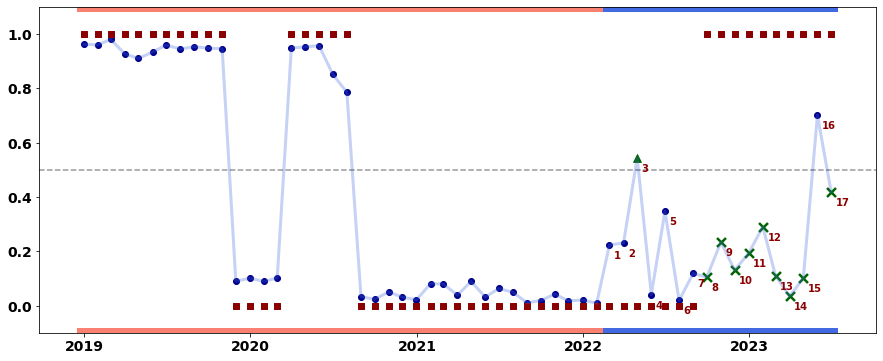

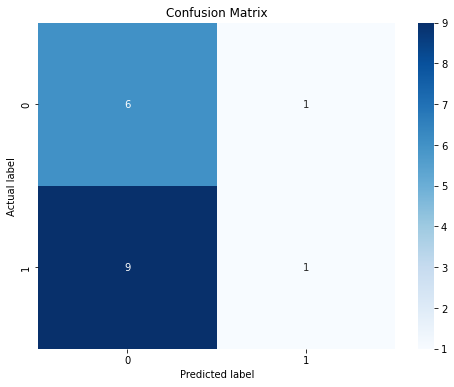

-----



In [454]:
for dir_name in dir_list:
    folder = dir_name
    company = folder.split('_')[0]
    ncol_xx0 = int(folder.split('_')[0][:2])
    ws = int(folder.split('_')[1])

    print(folder)
    print()

    # full_lambda = pd.read_csv(f'../02 Modeling/{folder}/full_lambda.csv', index_col=0, parse_dates=True)
    # full_lambda_mean = full_lambda.mean(axis=1)

    # FRM = pd.DataFrame()
    # for lag in range(ws):
    #     FRM[f'FRM_lag_{lag}'] = full_lambda_mean.shift(lag)
    # FRM = FRM.dropna()

    # SVI_lag = pd.DataFrame()
    # for lag in range(ws):
    #     SVI_lag[f'SVI_lag_{lag}'] = SVI['金融危機'].shift(lag)
    # SVI_lag = SVI_lag.dropna()

    # VIXTWN_lag = pd.DataFrame()
    # for lag in range(ws):
    #     VIXTWN_lag[f'VIXTWN_lag_{lag}'] = VIXTWN['VIXTWN'].shift(lag)
    # VIXTWN_lag = VIXTWN_lag.dropna()

    full_lambda = pd.read_csv(f'../02 Modeling/{folder}/full_lambda.csv', index_col=0, parse_dates=True)
    full_lambda_mean = full_lambda.mean(axis=1)

    full_lambda_mean_weekly = full_lambda_mean.resample('W-FRI').mean()
    full_lambda_mean_weekly = full_lambda_mean_weekly.dropna()

    full_lambda_mean_monthly = full_lambda_mean.resample('M').mean()
    full_lambda_mean_monthly = full_lambda_mean_monthly.dropna()

    FRM = pd.DataFrame()
    for lag in range(round(ws)):
        FRM[f'FRM_lag_{lag}'] = full_lambda_mean.shift(lag)
    FRM = FRM.dropna()
    FRM_std = std(FRM)

    FRM_weekly = pd.DataFrame()
    for lag in range(round(ws/5)):
        FRM_weekly[f'FRM_lag_{lag}'] = full_lambda_mean_weekly.shift(lag)
    FRM_weekly = FRM_weekly.dropna()
    FRM_weekly_std = std(FRM_weekly)

    FRM_weekly_lag = FRM.resample('W-FRI').last()
    FRM_weekly_lag = FRM_weekly_lag.dropna()
    FRM_weekly_lag_std = std(FRM_weekly_lag)

    FRM_weekly_diff_lag = FRM_weekly_lag - FRM_weekly_lag.shift(1)
    FRM_weekly_diff_lag = FRM_weekly_diff_lag.dropna()
    FRM_weekly_diff_lag_std = std(FRM_weekly_diff_lag)

    FRM_monthly = pd.DataFrame()
    for lag in range(6):
        FRM_monthly[f'FRM_lag_{lag}'] = full_lambda_mean_monthly.shift(lag)
    FRM_monthly = FRM_monthly.dropna()
    FRM_monthly_std = std(FRM_monthly)
    
    FRM_monthly_lag = FRM.resample('M').last()
    FRM_monthly_lag_std = std(FRM_monthly_lag)

    # FRM_monthly_lag = pd.DataFrame()
    # for lag in range(6):
    #     FRM_monthly_lag[f'FRM_monthly_lag_{lag}'] = full_lambda_mean_monthly.shift(lag)
    # FRM_monthly_lag = FRM_monthly_lag.dropna()
    # FRM_monthly_lag_std = std(FRM_monthly_lag)


    # FRM_monthly_diff_lag = FRM_monthly_lag - FRM_monthly_lag.shift(1)
    # FRM_monthly_diff_lag = FRM_monthly_diff_lag.dropna()
    # FRM_monthly_diff_lag = FRM_monthly_diff_lag.loc[FRM_monthly.index]
    # FRM_monthly_diff_lag_std = std(FRM_monthly_diff_lag)

    SVI_lag = pd.DataFrame()
    for lag in range(round(ws)):
        SVI_lag[f'SVI_lag_{lag}'] = SVI['金融危機'].shift(lag)
    SVI_lag = SVI_lag.dropna()
    SVI_lag_std = std(SVI_lag)

    SVI_weekly = SVI['金融危機'].resample('W-FRI').mean()
    SVI_weekly = SVI_weekly.dropna()
    SVI_weekly_std = std(pd.DataFrame(SVI_weekly))

    SVI_lag_weekly = pd.DataFrame()
    for lag in range(round(ws/5)):
        SVI_lag_weekly[f'SVI_lag_{lag}'] = SVI_weekly.shift(lag)
    SVI_lag_weekly = SVI_lag_weekly.dropna()
    SVI_lag_weekly_std = std(SVI_lag_weekly)

    SVI_monthly = SVI['金融危機'].resample('M').mean()
    SVI_monthly = SVI_monthly.dropna()
    SVI_monthly_std = std(pd.DataFrame(SVI_monthly))

    SVI_lag_monthly = pd.DataFrame()
    for lag in range(6):
        SVI_lag_monthly[f'SVI_lag_{lag}'] = SVI_monthly.shift(lag)
    SVI_lag_monthly = SVI_lag_monthly.dropna()
    SVI_lag_monthly_std = std(SVI_lag_monthly)

    SVI_monthly_lag = SVI_lag.resample('M').last()
    SVI_monthly_lag_std = std(SVI_monthly_lag)

    VIXTWN_lag = pd.DataFrame()
    for lag in range(round(ws)):
        VIXTWN_lag[f'VIXTWN_lag_{lag}'] = VIXTWN['VIXTWN'].shift(lag)
    VIXTWN_lag = VIXTWN_lag.dropna()
    VIXTWN_lag_std = std(VIXTWN_lag)

    VIXTWN_weekly = VIXTWN.resample('W-FRI').mean()
    VIXTWN_weekly = VIXTWN_weekly.dropna()
    VIXTWN_weekly_std = std(VIXTWN_weekly)

    VIXTWN_lag_weekly = pd.DataFrame()
    for lag in range(round(ws/5)):
        VIXTWN_lag_weekly[f'VIXTWN_lag_{lag}'] = VIXTWN_weekly.shift(lag)
    VIXTWN_lag_weekly = VIXTWN_lag_weekly.dropna()
    VIXTWN_lag_weekly_std = std(VIXTWN_lag_weekly)

    VIXTWN_monthly = VIXTWN.resample('M').mean()
    VIXTWN_montly = VIXTWN_monthly.dropna()
    VIXTWN_monthly_std = std(VIXTWN_monthly)

    VIXTWN_lag_monthly = pd.DataFrame()
    for lag in range(6):
        VIXTWN_lag_monthly[f'VIXTWN_lag_{lag}'] = VIXTWN_monthly.shift(lag)
    VIXTWN_lag_monthly = VIXTWN_lag_monthly.dropna()
    VIXTWN_lag_monthly_std = std(VIXTWN_lag_monthly)

    VIXTWN_monthly_lag = VIXTWN_lag.resample('M').last()
    VIXTWN_monthly_lag_std = std(VIXTWN_monthly_lag)

    BCI_daily = BCI.resample('D').ffill()
    BCI_daily = BCI_daily.loc[FRM.index]
    BCI_daily_std = std(BCI_daily)

    BCI_weekly = BCI.resample('W-FRI').ffill()
    BCI_weekly = BCI_weekly.dropna()
    BCI_weekly = BCI_weekly.loc[FRM_weekly.index]
    BCI_weekly_std = std(BCI_weekly)

    BCI_Real_daily = BCI_Real.resample('D').ffill()
    BCI_Real_daily = BCI_Real_daily.loc[FRM.index]
    BCI_Real_daily_std = std(BCI_Real_daily)

    BCI_Real_weekly = BCI_Real.resample('W-FRI').ffill()
    BCI_Real_weekly = BCI_Real_weekly.loc[FRM_weekly.index]
    BCI_Real_weekly_std = std(BCI_Real_weekly)

    LEI_daily = LEI.resample('D').ffill()
    LEI_daily = LEI_daily.loc[FRM.index]
    LEI_daily_std = std(LEI_daily)

    LEI_weekly = LEI.resample('W-FRI').ffill()
    LEI_weekly = LEI_weekly.loc[FRM_weekly.index]
    LEI_weekly_std = std(LEI_weekly)

    LEI_lag = pd.DataFrame()
    for lag in range(6):
        LEI_lag[f'LEI_lag_{lag}'] = LEI.shift(lag)
    LEI_lag = LEI_lag.dropna()
    LEI_lag_std = std(LEI_lag)

    COI_daily = COI.resample('D').ffill()
    COI_daily = COI_daily.loc[FRM.index]
    COI_daily_std = std(COI_daily)

    COI_weekly = COI.resample('W-FRI').ffill()
    COI_weekly = COI_weekly.loc[FRM_weekly.index]
    COI_weekly_std = std(COI_weekly)

    COI_lag = pd.DataFrame()
    for lag in range(6):
        COI_lag[f'COI_lag_{lag}'] = COI.shift(lag)
    COI_lag = COI_lag.dropna()
    COI_lag_std = std(COI_lag)

    LAI_daily = LAI.resample('D').ffill()
    LAI_daily = LAI_daily.loc[FRM.index]
    LAI_daily_std = std(LAI_daily)

    LAI_weekly = LAI.resample('W-FRI').ffill()
    LAI_weekly = LAI_weekly.loc[FRM_weekly.index]
    LAI_weekly_std = std(LAI_weekly)

    LAI_lag = pd.DataFrame()
    for lag in range(6):
        LAI_lag[f'LAI_lag_{lag}'] = LAI.shift(lag)
    LAI_lag = LAI_lag.dropna()
    LAI_lag_std = std(LAI_lag)

    macro_daily = macro.loc[FRM.index]
    macro_daily_std = std(macro_daily)

    macro_weekly = macro.resample('W-FRI').mean()
    macro_weekly = macro_weekly.dropna()
    macro_weekly = macro_weekly.loc[FRM_weekly.index]
    macro_weekly_std = std(macro_weekly)

    macro_monthly = macro.resample('M').mean()
    macro_monthly = macro_monthly.dropna()
    macro_monthly = macro_monthly.loc[FRM_monthly.index]
    macro_monthly_std = std(macro_monthly)

    SVI_daily = SVI_lag.loc[FRM.index]
    SVI_daily_std = std(SVI_daily)

    SVI_lag_weekly = SVI_lag_weekly.loc[FRM_weekly.index]
    SVI_lag_weekly_std = std(SVI_lag_weekly)

    SVI_lag_monthly = SVI_lag_monthly.loc[FRM_monthly.index]
    SVI_lag_monthly_std = std(SVI_lag_monthly)

    VIXTWN_daily = VIXTWN_lag.loc[FRM.index]
    VIXTWN_daily_std = std(VIXTWN_daily)

    VIXTWN_lag_weekly = VIXTWN_lag_weekly.loc[FRM_weekly.index]
    VIXTWN_lag_weekly_std = std(VIXTWN_lag_weekly)

    VIXTWN_lag_monthly = VIXTWN_lag_monthly.loc[FRM_monthly.index]
    VIXTWN_lag_monthly_std = std(VIXTWN_lag_monthly)

    BCI_daily['Recession'] = BCI_daily['BCI'].apply(score_to_recession)
    BCI_daily_std['Recession'] = BCI_daily['BCI'].apply(score_to_recession)

    BCI_Real_daily['Recession'] = BCI_Real_daily['BCI'].apply(score_to_recession)
    BCI_Real_daily_std['Recession'] = BCI_Real_daily['BCI'].apply(score_to_recession)

    BCI_weekly['Recession'] = BCI_weekly['BCI'].apply(score_to_recession)
    BCI_weekly_std['Recession'] = BCI_weekly['BCI'].apply(score_to_recession)

    BCI_Real_weekly['Recession'] = BCI_Real_weekly['BCI'].apply(score_to_recession)
    BCI_Real_weekly_std['Recession'] = BCI_Real_weekly['BCI'].apply(score_to_recession)

    BCI_monthly = pd.DataFrame()
    BCI_monthly['BCI'] = BCI['BCI']
    BCI_monthly = BCI_monthly.loc[FRM_monthly_lag.index]
    BCI_monthly_std = std(BCI_monthly)

    BCI_monthly['Recession'] = BCI['BCI'].apply(score_to_recession)
    BCI_monthly_std['Recesion'] = BCI['BCI'].apply(score_to_recession)

    BCI_Real_monthly = pd.DataFrame()
    BCI_Real_monthly['BCI'] = BCI_Real['BCI']
    BCI_Real_monthly = BCI_monthly.loc[FRM_monthly_lag.index]
    BCI_Real_monthly_std = std(BCI_Real_monthly)

    BCI_Real_monthly['Recession'] = BCI_Real['BCI'].apply(score_to_recession)
    BCI_Real_monthly_std['Recession'] = BCI_Real['BCI'].apply(score_to_recession)

    BCI_monthly_lag = pd.DataFrame()
    BCI_monthly_lag['BCI'] = BCI['BCI']
    BCI_monthly_lag = BCI_monthly_lag.loc[FRM_monthly_lag.index]
    BCI_monthly_lag_std = std(BCI_monthly)

    BCI_monthly_lag['Recession'] = BCI['BCI'].apply(score_to_recession)
    BCI_monthly_lag_std['Recession'] = BCI['BCI'].apply(score_to_recession)

    BCI_Real_monthly_lag = pd.DataFrame()
    BCI_Real_monthly_lag['BCI'] = BCI_Real['BCI']
    BCI_Real_monthly_lag = BCI_monthly_lag.loc[FRM_monthly_lag.index]
    BCI_Real_monthly_lag_std = std(BCI_Real_monthly_lag)

    BCI_Real_monthly_lag['Recession'] = BCI_Real['BCI'].apply(score_to_recession)
    BCI_Real_monthly_lag_std['Recession'] = BCI_Real['BCI'].apply(score_to_recession)
    
    ######

    data_chooses = ['F', 'V', 'F+B', 'V+B', 'F+V', 'F+V+B']
    data_chooses = ['F', 'V', 'F+V']
    # data_chooses = ['F']
    # A = [BCI_daily, SVI_daily, VIXTWN_daily]
    # A = [macro_daily, SVI_daily]
    # B = [FRM]

    F = [FRM_monthly_lag_std]
    V = [SVI_monthly_lag_std.loc[FRM_monthly_lag_std.index], VIXTWN_monthly_lag_std.loc[FRM_monthly_lag_std.index]]
    B = [LEI_lag_std.loc[FRM_monthly_lag_std.index], COI_lag_std.loc[FRM_monthly_lag_std.index], LAI_lag_std.loc[FRM_monthly_lag_std.index]]

    # F = [FRM_monthly_lag_std]
    # V = [SVI_lag_monthly_std.loc[FRM_monthly_lag_std.index], VIXTWN_lag_monthly_std.loc[FRM_monthly_lag_std.index]]
    # B = [LEI_lag_std.loc[FRM_monthly_lag_std.index], COI_lag_std.loc[FRM_monthly_lag_std.index], LAI_lag_std.loc[FRM_monthly_lag_std.index]]

    X_bm = pd.concat(B, axis=1)
    y_bm = BCI_Real_monthly_std['Recession']
    y_pred_train_lr, y_pred_test_lr, y_pred_proba_train_lr, y_pred_proba_test_lr, y_pred_train_xgb, y_pred_test_xgb, y_pred_proba_train_xgb, y_pred_proba_test_xgb = bm_model(X_bm, y_bm)

    for data_choose in data_chooses:
        print('-----')
        print()

        if data_choose == 'F':
            X = pd.concat(F, axis=1)
            X_name = 'F'
        elif data_choose == 'V':
            X = pd.concat(V, axis=1)
        elif data_choose == 'F+B':
            X = pd.concat(F + B, axis=1)
        elif data_choose == 'V+B':
            X = pd.concat(V + B, axis=1)
        elif data_choose == 'F+V':
            X = pd.concat(F + V, axis=1)
        elif data_choose == 'F+V+B':
            X = pd.concat(F + V + B, axis=1)
        
        y = BCI_Real_monthly_std['Recession']
        y_pred_train, y_pred_test, y_pred_proba_train, y_pred_proba_test = performance(X, y, data_choose, BCI_Real_monthly)

Benchmark

Benchmark, Logistic Regression
In-sample Accuracy   = 1.0000
In-sample Precision  = 1.0000
In-sample Recall     = 1.0000
In-sample F1 Score   = 1.0000
In-sample AUC-ROC    = 1.0000
Out-sample Accuracy  = 0.8824
Out-sample Precision = 1.0000
Out-sample Recall    = 0.8000
Out-sample F1 Score  = 0.8889
Out-sample AUC-ROC   = 1.0000



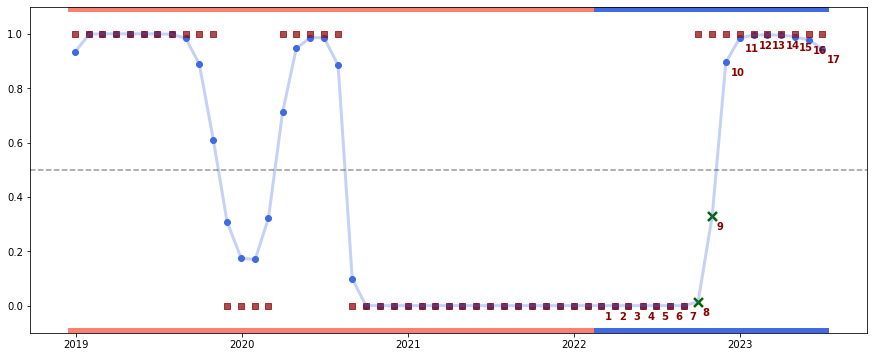

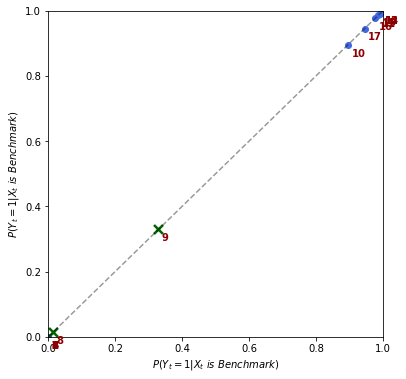

Benchmark, XGBoost
In-sample Accuracy   = 1.0000
In-sample Precision  = 1.0000
In-sample Recall     = 1.0000
In-sample F1 Score   = 1.0000
In-sample AUC-ROC    = 1.0000
Out-sample Accuracy  = 0.5882
Out-sample Precision = 0.5882
Out-sample Recall    = 1.0000
Out-sample F1 Score  = 0.7407
Out-sample AUC-ROC   = 0.9571



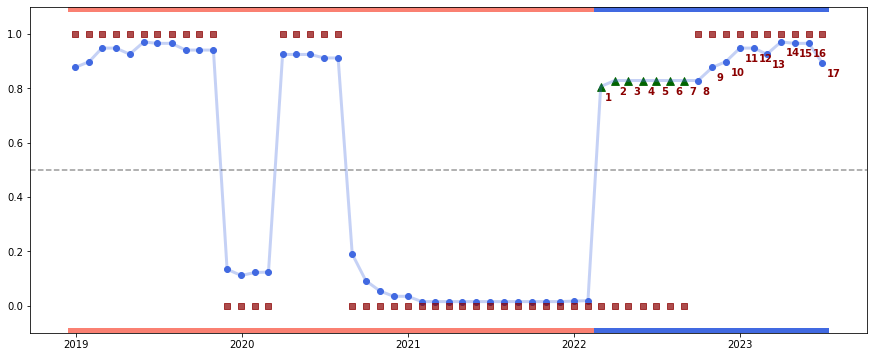

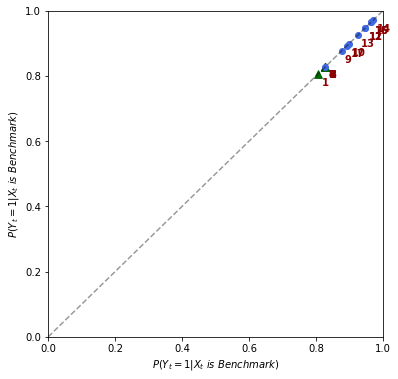

In [383]:
print('Benchmark')
print()

X_bm = pd.concat(B, axis=1)
y_bm = BCI_Real_monthly_std['Recession']
folder = '../05 Benchmark'

# def performance(X, y, data_choose, BCI_Real_monthly):
n = len(X_bm)
train_size = int(n * 0.7)

X_train, X_test = X_bm[:train_size], X_bm[train_size:]
y_train, y_test = y_bm[:train_size], y_bm[train_size:]

models = {
    "Logistic Regression": LogisticRegression(C=10, max_iter=10000, random_state=42, multi_class='ovr'),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42)
}

model_performance = {}

for name, model in models.items():
    print('Benchmark,', name)
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]

    print('In-sample Accuracy   =', f'{accuracy_score(y_train, y_pred_train):.4f}')
    print('In-sample Precision  =', f'{precision_score(y_train, y_pred_train):.4f}')
    print('In-sample Recall     =', f'{recall_score(y_train, y_pred_train):.4f}')
    print('In-sample F1 Score   =', f'{f1_score(y_train, y_pred_train):.4f}')
    print('In-sample AUC-ROC    =', f'{roc_auc_score(y_train, y_pred_proba_train):.4f}')
    print('Out-sample Accuracy  =', f'{accuracy_score(y_test, y_pred_test):.4f}')
    print('Out-sample Precision =', f'{precision_score(y_test, y_pred_test):.4f}')
    print('Out-sample Recall    =', f'{recall_score(y_test, y_pred_test):.4f}')
    print('Out-sample F1 Score  =', f'{f1_score(y_test, y_pred_test):.4f}')
    print('Out-sample AUC-ROC   =', f'{roc_auc_score(y_test, y_pred_proba_test):.4f}')
    print()

    predict_proba_train = pd.DataFrame(y_pred_proba_train)
    predict_proba_test = pd.DataFrame(y_pred_proba_test)
    predict_proba = pd.concat([predict_proba_train, predict_proba_test], axis=0)
    predict_proba.index = X_bm.index

    plt.figure(figsize=(15,6))

    train_test_split = len(predict_proba_train)

    plt.hlines(y = 1.1, xmin=predict_proba.index[0] - pd.DateOffset(days=15), xmax=predict_proba.index[train_test_split] - pd.DateOffset(days=15), color='salmon', linestyle='-', linewidth=10)
    plt.hlines(y = -0.1, xmin=predict_proba.index[0] - pd.DateOffset(days=15), xmax=predict_proba.index[train_test_split] - pd.DateOffset(days=15), color='salmon', linestyle='-', linewidth=10)
    plt.hlines(y = 1.1, xmin=predict_proba.index[train_test_split]- pd.DateOffset(days=15), xmax= predict_proba.index[-1] + pd.DateOffset(days=15), color='royalblue', linestyle='-', linewidth=10)
    plt.hlines(y = -0.1, xmin=predict_proba.index[train_test_split]- pd.DateOffset(days=15), xmax= predict_proba.index[-1] + pd.DateOffset(days=15), color='royalblue', linestyle='-', linewidth=10)
    plt.plot(predict_proba, linewidth=3, color='royalblue', alpha=0.3)

    start_index = int(len(predict_proba) * 0.7)
    for i in range(len(predict_proba)):
        if BCI_Real_monthly['Recession'].iloc[i] == 1 and predict_proba.values[i] < 0.5:
            plt.scatter(predict_proba.index[i], predict_proba.values[i], color='darkgreen', marker='x', s=80, lw=2.5, alpha=1)
        elif BCI_Real_monthly['Recession'].iloc[i] == 0 and predict_proba.values[i] > 0.5:
            plt.scatter(predict_proba.index[i], predict_proba.values[i], color='darkgreen', marker='^', s=60, lw=1, alpha=1)
        else:
            plt.scatter(predict_proba.index[i], predict_proba.values[i], color='royalblue', alpha=1)
        if i >= start_index:
            date_num = mdates.date2num(predict_proba.index[i])
            offset_x = 10
            plt.text(date_num + offset_x, predict_proba.values[i] - 0.02, str(i - start_index + 1), 
                    color='darkred', fontsize=10, fontweight='heavy', ha='left', va='top')

    plt.scatter(BCI_Real_monthly['Recession'].index, BCI_Real_monthly['Recession'], color='darkred', marker='s', alpha=0.7)
    plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.4)
    plt.ylim(-0.1, 1.1)
    plt.savefig(f'{folder}/Result_{data_choose}_{name}.png', dpi=144, transparent=True)
    plt.show()

    if name == 'Logistic Regression':
        z = np.dot(X_bm, model.coef_.T) + model.intercept_
        y_pred_combined = np.concatenate([y_pred_train, y_pred_test])
        y_pred_combined = pd.DataFrame(y_pred_combined)
        y_pred_combined.index = y_bm.index
        y_pred_combined.columns = ['Recession']

        z = pd.DataFrame(z)
        z.columns = ['z']
        z.index = X_bm.index
        z = pd.concat([z, y_pred_combined], axis=1)

        def sigmoid(z):
            return 1 / (1 + np.exp(-z))
        z['sigmoid'] = sigmoid(z['z'])

        # plt.figure(figsize=(15, 5))
        # plt.scatter(z['z'], z['Recession'], label='Real')
        # plt.plot(z['z'], z['sigmoid'], 'ro', label='Sigmoid prob')
        # plt.xlabel(r'$\theta^T$$X$')
        # plt.xlim(-6.5, 6.5)
        # plt.savefig(f'{folder}/Sigmoid_{data_choose}.png', dpi=144, transparent=True)
        # plt.show()

        z_test = np.dot(X_test, model.coef_.T) + model.intercept_
        y_pred_combined = np.concatenate([y_pred_test])
        y_pred_combined = pd.DataFrame(y_pred_combined)
        y_pred_combined.index = y_test.index
        y_pred_combined.columns = ['Recession']

        z_test = pd.DataFrame(z_test)
        z_test.columns = ['z']
        z_test.index = X_test.index
        z_test = pd.concat([z_test, y_pred_combined], axis=1)
        # 假設 test_z 是您提供的 DataFrame
        # 這裡 z 是模型的線性組合輸出，Recession 是實際的類別標籤

        def sigmoid(z):
            return 1 / (1 + np.exp(-z))

        z_test['sigmoid'] = sigmoid(z_test['z'])

        # plt.figure(figsize=(15, 5))
        # plt.scatter(z_test['z'], z_test['Recession'], label='Real')
        # plt.plot(z_test['z'], z_test['sigmoid'], 'ro', label='Sigmoid prob')
        # for i in range(len(z_test)):
        #     plt.text(z_test['z'][i], z_test['Recession'][i], z_test.index[i].strftime('%y/%m'), fontsize=9, ha='left', va='bottom')
        # plt.xlabel(r'$\theta^T$$X$')
        # plt.xlim(-1.5, 4)
        # plt.savefig(f'{folder}/Sigmoid_test_{data_choose}.png', dpi=144, transparent=True)
        # plt.show()
    
        plt.figure(figsize=(6,6))
        for i in range(len(y_pred_proba_test)):
            if BCI_Real_monthly['Recession'].iloc[len(BCI_Real_monthly) - len(y_pred_proba_test) + i] == 1 and y_pred_proba_test[i] < 0.5:
                plt.scatter(y_pred_proba_test_lr[i], y_pred_proba_test[i], color='darkgreen', marker='x', s=80, lw=2.5, alpha=1)
            elif BCI_Real_monthly['Recession'].iloc[len(BCI_Real_monthly) - len(y_pred_proba_test) + i] == 0 and y_pred_proba_test[i] > 0.5:
                plt.scatter(y_pred_proba_test_lr[i], y_pred_proba_test[i], color='darkgreen', marker='^', s=60, lw=1, alpha=1)
            else:
                plt.scatter(y_pred_proba_test_lr[i], y_pred_proba_test[i], color='royalblue', alpha=1)

        for i, (x, y) in enumerate(zip(y_pred_proba_test_lr, y_pred_proba_test)):
            plt.text(x+0.01, y-0.01, str(i + 1), color='darkred', fontweight='heavy', fontsize=10, ha='left', va='top')

        plt.xlabel(r'$P(Y_t=1|X_t$ $is$ $Benchmark)$')
        plt.ylabel(r'$P(Y_t=1|X_t$ $is$ $Benchmark)$')
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.4)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.savefig(f'{folder}/Scatter plot_{data_choose}_{name}', dpi=144, transparent=True)
        plt.show()
    
    if name == 'XGBoost':
        plt.figure(figsize=(6,6))

        for i in range(len(y_pred_proba_test)):
            if BCI_Real_monthly['Recession'].iloc[len(BCI_Real_monthly) - len(y_pred_proba_test) + i] == 1 and y_pred_proba_test[i] < 0.5:
                plt.scatter(y_pred_proba_test_xgb[i], y_pred_proba_test[i], color='darkgreen', marker='x', s=80, lw=2.5, alpha=1)
            elif BCI_Real_monthly['Recession'].iloc[len(BCI_Real_monthly) - len(y_pred_proba_test) + i] == 0 and y_pred_proba_test[i] > 0.5:
                plt.scatter(y_pred_proba_test_xgb[i], y_pred_proba_test[i], color='darkgreen', marker='^', s=60, lw=1, alpha=1)
            else:
                plt.scatter(y_pred_proba_test_xgb[i], y_pred_proba_test[i], color='royalblue', alpha=1)

        # plt.scatter(y_pred_proba_test_xgb, y_pred_proba_test)
        for i, (x, y) in enumerate(zip(y_pred_proba_test_xgb, y_pred_proba_test)):
            plt.text(x+0.01, y-0.01, str(i + 1), color='darkred', fontweight='heavy', fontsize=10, ha='left', va='top')
        plt.xlabel(r'$P(Y_t=1|X_t$ $is$ $Benchmark)$')
        plt.ylabel(r'$P(Y_t=1|X_t$ $is$ $Benchmark)$')
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.4)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.savefig(f'{folder}/Scatter plot_{data_choose}_{name}', dpi=144, transparent=True)
        plt.show()

In [385]:
SVI_lag_monthly

,SVI_lag_0,SVI_lag_1,SVI_lag_2,SVI_lag_3,SVI_lag_4,SVI_lag_5
2019-02-28,9.919996,4.071992,9.006289,4.806543,7.186663,8.976936
2019-03-31,8.116443,9.919996,4.071992,9.006289,4.806543,7.186663
2019-04-30,5.057944,8.116443,9.919996,4.071992,9.006289,4.806543
2019-05-31,4.994384,5.057944,8.116443,9.919996,4.071992,9.006289
2019-06-30,4.881394,4.994384,5.057944,8.116443,9.919996,4.071992
2019-07-31,9.862555,4.881394,4.994384,5.057944,8.116443,9.919996
2019-08-31,4.237112,9.862555,4.881394,4.994384,5.057944,8.116443
2019-09-30,1.974915,4.237112,9.862555,4.881394,4.994384,5.057944
2019-10-31,8.722141,1.974915,4.237112,9.862555,4.881394,4.994384
2019-11-30,5.403070,8.722141,1.974915,4.237112,9.862555,4.881394


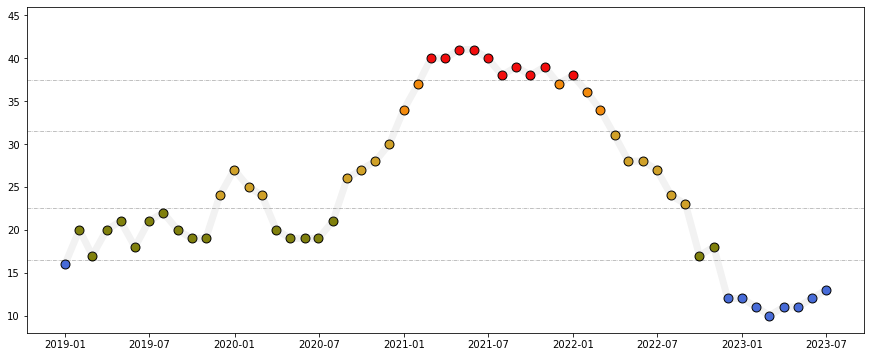

In [379]:
BCI_plot = BCI_Real.loc[FRM.resample('M').last().index]
plt.figure(figsize=(15, 6))
plt.plot(BCI_plot['BCI'], color='gray', linewidth=7, alpha=0.1)
plt.axhline(y=16.5, color='black', linestyle='-.', linewidth=0.6, alpha=0.4)
plt.axhline(y=22.5, color='black', linestyle='-.', linewidth=0.6, alpha=0.4)
plt.axhline(y=31.5, color='black', linestyle='-.', linewidth=0.6, alpha=0.4)
plt.axhline(y=37.5, color='black', linestyle='-.', linewidth=0.6, alpha=0.4)
for i in range(len(BCI_plot)):
    if BCI_plot['BCI'].iloc[i] < 17 :
        plt.scatter(BCI_plot.index[i], BCI_plot['BCI'][i], color='royalblue', s=80, edgecolors='black', alpha=1)
    elif BCI_plot['BCI'].iloc[i] < 23:
        plt.scatter(BCI_plot.index[i], BCI_plot['BCI'][i], color='olive', s=80, edgecolors='black', alpha=1)
    elif BCI_plot['BCI'].iloc[i] < 32:
        plt.scatter(BCI_plot.index[i], BCI_plot['BCI'][i], color='goldenrod', s=80, edgecolors='black', alpha=1)
    elif BCI_plot['BCI'].iloc[i] < 38:
        plt.scatter(BCI_plot.index[i], BCI_plot['BCI'][i], color='darkorange', s=80, edgecolors='black', alpha=1)
    else:
        plt.scatter(BCI_plot.index[i], BCI_plot['BCI'][i], color='red', s=80, edgecolors='black', alpha=1)
plt.ylim(8, 46)
plt.savefig('../06 Figure/BCI.png', dpi=144, transparent=True)
plt.show()

In [382]:
len(X_test)

17

In [414]:
dir_name = '50elefin_63'
folder = dir_name
company = folder.split('_')[0]
ncol_xx0 = int(folder.split('_')[0][:2])
ws = int(folder.split('_')[1])

print(folder)
print()

# full_lambda = pd.read_csv(f'../02 Modeling/{folder}/full_lambda.csv', index_col=0, parse_dates=True)
# full_lambda_mean = full_lambda.mean(axis=1)

# FRM = pd.DataFrame()
# for lag in range(ws):
#     FRM[f'FRM_lag_{lag}'] = full_lambda_mean.shift(lag)
# FRM = FRM.dropna()

# SVI_lag = pd.DataFrame()
# for lag in range(ws):
#     SVI_lag[f'SVI_lag_{lag}'] = SVI['金融危機'].shift(lag)
# SVI_lag = SVI_lag.dropna()

# VIXTWN_lag = pd.DataFrame()
# for lag in range(ws):
#     VIXTWN_lag[f'VIXTWN_lag_{lag}'] = VIXTWN['VIXTWN'].shift(lag)
# VIXTWN_lag = VIXTWN_lag.dropna()

full_lambda = pd.read_csv(f'../02 Modeling/{folder}/full_lambda.csv', index_col=0, parse_dates=True)
full_lambda_mean = full_lambda.mean(axis=1)

full_lambda_mean_weekly = full_lambda_mean.resample('W-FRI').mean()
full_lambda_mean_weekly = full_lambda_mean_weekly.dropna()

full_lambda_mean_monthly = full_lambda_mean.resample('M').mean()
full_lambda_mean_monthly = full_lambda_mean_monthly.dropna()

FRM = pd.DataFrame()
for lag in range(round(ws)):
    FRM[f'FRM_lag_{lag}'] = full_lambda_mean.shift(lag)
FRM = FRM.dropna()
FRM_std = std(FRM)

FRM_weekly = pd.DataFrame()
for lag in range(round(ws/5)):
    FRM_weekly[f'FRM_lag_{lag}'] = full_lambda_mean_weekly.shift(lag)
FRM_weekly = FRM_weekly.dropna()
FRM_weekly_std = std(FRM_weekly)

FRM_weekly_lag = FRM.resample('W-FRI').last()
FRM_weekly_lag = FRM_weekly_lag.dropna()
FRM_weekly_lag_std = std(FRM_weekly_lag)

FRM_weekly_diff_lag = FRM_weekly_lag - FRM_weekly_lag.shift(1)
FRM_weekly_diff_lag = FRM_weekly_diff_lag.dropna()
FRM_weekly_diff_lag_std = std(FRM_weekly_diff_lag)

FRM_monthly = pd.DataFrame()
for lag in range(6):
    FRM_monthly[f'FRM_lag_{lag}'] = full_lambda_mean_monthly.shift(lag)
FRM_monthly = FRM_monthly.dropna()
FRM_monthly_std = std(FRM_monthly)

FRM_monthly_lag = FRM.resample('M').last()
FRM_monthly_lag_std = std(FRM_monthly_lag)

# FRM_monthly_lag = pd.DataFrame()
# for lag in range(6):
#     FRM_monthly_lag[f'FRM_monthly_lag_{lag}'] = full_lambda_mean_monthly.shift(lag)
# FRM_monthly_lag = FRM_monthly_lag.dropna()
# FRM_monthly_lag_std = std(FRM_monthly_lag)


# FRM_monthly_diff_lag = FRM_monthly_lag - FRM_monthly_lag.shift(1)
# FRM_monthly_diff_lag = FRM_monthly_diff_lag.dropna()
# FRM_monthly_diff_lag = FRM_monthly_diff_lag.loc[FRM_monthly.index]
# FRM_monthly_diff_lag_std = std(FRM_monthly_diff_lag)

SVI_lag = pd.DataFrame()
for lag in range(round(ws)):
    SVI_lag[f'SVI_lag_{lag}'] = SVI['金融危機'].shift(lag)
SVI_lag = SVI_lag.dropna()
SVI_lag_std = std(SVI_lag)

SVI_weekly = SVI['金融危機'].resample('W-FRI').mean()
SVI_weekly = SVI_weekly.dropna()
SVI_weekly_std = std(pd.DataFrame(SVI_weekly))

SVI_lag_weekly = pd.DataFrame()
for lag in range(round(ws/5)):
    SVI_lag_weekly[f'SVI_lag_{lag}'] = SVI_weekly.shift(lag)
SVI_lag_weekly = SVI_lag_weekly.dropna()
SVI_lag_weekly_std = std(SVI_lag_weekly)

SVI_monthly = SVI['金融危機'].resample('M').mean()
SVI_monthly = SVI_monthly.dropna()
SVI_monthly_std = std(pd.DataFrame(SVI_monthly))

SVI_lag_monthly = pd.DataFrame()
for lag in range(6):
    SVI_lag_monthly[f'SVI_lag_{lag}'] = SVI_monthly.shift(lag)
SVI_lag_monthly = SVI_lag_monthly.dropna()
SVI_lag_monthly_std = std(SVI_lag_monthly)

SVI_monthly_lag = SVI_lag.resample('M').last()
SVI_monthly_lag_std = std(SVI_monthly_lag)

VIXTWN_lag = pd.DataFrame()
for lag in range(round(ws)):
    VIXTWN_lag[f'VIXTWN_lag_{lag}'] = VIXTWN['VIXTWN'].shift(lag)
VIXTWN_lag = VIXTWN_lag.dropna()
VIXTWN_lag_std = std(VIXTWN_lag)

VIXTWN_weekly = VIXTWN.resample('W-FRI').mean()
VIXTWN_weekly = VIXTWN_weekly.dropna()
VIXTWN_weekly_std = std(VIXTWN_weekly)

VIXTWN_lag_weekly = pd.DataFrame()
for lag in range(round(ws/5)):
    VIXTWN_lag_weekly[f'VIXTWN_lag_{lag}'] = VIXTWN_weekly.shift(lag)
VIXTWN_lag_weekly = VIXTWN_lag_weekly.dropna()
VIXTWN_lag_weekly_std = std(VIXTWN_lag_weekly)

VIXTWN_monthly = VIXTWN.resample('M').mean()
VIXTWN_montly = VIXTWN_monthly.dropna()
VIXTWN_monthly_std = std(VIXTWN_monthly)

VIXTWN_lag_monthly = pd.DataFrame()
for lag in range(6):
    VIXTWN_lag_monthly[f'VIXTWN_lag_{lag}'] = VIXTWN_monthly.shift(lag)
VIXTWN_lag_monthly = VIXTWN_lag_monthly.dropna()
VIXTWN_lag_monthly_std = std(VIXTWN_lag_monthly)

VIXTWN_monthly_lag = VIXTWN_lag.resample('M').last()
VIXTWN_monthly_lag_std = std(VIXTWN_monthly_lag)

BCI_daily = BCI.resample('D').ffill()
BCI_daily = BCI_daily.loc[FRM.index]
BCI_daily_std = std(BCI_daily)

BCI_weekly = BCI.resample('W-FRI').ffill()
BCI_weekly = BCI_weekly.dropna()
BCI_weekly = BCI_weekly.loc[FRM_weekly.index]
BCI_weekly_std = std(BCI_weekly)

BCI_Real_daily = BCI_Real.resample('D').ffill()
BCI_Real_daily = BCI_Real_daily.loc[FRM.index]
BCI_Real_daily_std = std(BCI_Real_daily)

BCI_Real_weekly = BCI_Real.resample('W-FRI').ffill()
BCI_Real_weekly = BCI_Real_weekly.loc[FRM_weekly.index]
BCI_Real_weekly_std = std(BCI_Real_weekly)

LEI_daily = LEI.resample('D').ffill()
LEI_daily = LEI_daily.loc[FRM.index]
LEI_daily_std = std(LEI_daily)

LEI_weekly = LEI.resample('W-FRI').ffill()
LEI_weekly = LEI_weekly.loc[FRM_weekly.index]
LEI_weekly_std = std(LEI_weekly)

LEI_lag = pd.DataFrame()
for lag in range(6):
    LEI_lag[f'LEI_lag_{lag}'] = LEI.shift(lag)
LEI_lag = LEI_lag.dropna()
LEI_lag_std = std(LEI_lag)

COI_daily = COI.resample('D').ffill()
COI_daily = COI_daily.loc[FRM.index]
COI_daily_std = std(COI_daily)

COI_weekly = COI.resample('W-FRI').ffill()
COI_weekly = COI_weekly.loc[FRM_weekly.index]
COI_weekly_std = std(COI_weekly)

COI_lag = pd.DataFrame()
for lag in range(6):
    COI_lag[f'COI_lag_{lag}'] = COI.shift(lag)
COI_lag = COI_lag.dropna()
COI_lag_std = std(COI_lag)

LAI_daily = LAI.resample('D').ffill()
LAI_daily = LAI_daily.loc[FRM.index]
LAI_daily_std = std(LAI_daily)

LAI_weekly = LAI.resample('W-FRI').ffill()
LAI_weekly = LAI_weekly.loc[FRM_weekly.index]
LAI_weekly_std = std(LAI_weekly)

LAI_lag = pd.DataFrame()
for lag in range(6):
    LAI_lag[f'LAI_lag_{lag}'] = LAI.shift(lag)
LAI_lag = LAI_lag.dropna()
LAI_lag_std = std(LAI_lag)

macro_daily = macro.loc[FRM.index]
macro_daily_std = std(macro_daily)

macro_weekly = macro.resample('W-FRI').mean()
macro_weekly = macro_weekly.dropna()
macro_weekly = macro_weekly.loc[FRM_weekly.index]
macro_weekly_std = std(macro_weekly)

macro_monthly = macro.resample('M').mean()
macro_monthly = macro_monthly.dropna()
macro_monthly = macro_monthly.loc[FRM_monthly.index]
macro_monthly_std = std(macro_monthly)

SVI_daily = SVI_lag.loc[FRM.index]
SVI_daily_std = std(SVI_daily)

SVI_lag_weekly = SVI_lag_weekly.loc[FRM_weekly.index]
SVI_lag_weekly_std = std(SVI_lag_weekly)

SVI_lag_monthly = SVI_lag_monthly.loc[FRM_monthly.index]
SVI_lag_monthly_std = std(SVI_lag_monthly)

VIXTWN_daily = VIXTWN_lag.loc[FRM.index]
VIXTWN_daily_std = std(VIXTWN_daily)

VIXTWN_lag_weekly = VIXTWN_lag_weekly.loc[FRM_weekly.index]
VIXTWN_lag_weekly_std = std(VIXTWN_lag_weekly)

VIXTWN_lag_monthly = VIXTWN_lag_monthly.loc[FRM_monthly.index]
VIXTWN_lag_monthly_std = std(VIXTWN_lag_monthly)

BCI_daily['Recession'] = BCI_daily['BCI'].apply(score_to_recession)
BCI_daily_std['Recession'] = BCI_daily['BCI'].apply(score_to_recession)

BCI_Real_daily['Recession'] = BCI_Real_daily['BCI'].apply(score_to_recession)
BCI_Real_daily_std['Recession'] = BCI_Real_daily['BCI'].apply(score_to_recession)

BCI_weekly['Recession'] = BCI_weekly['BCI'].apply(score_to_recession)
BCI_weekly_std['Recession'] = BCI_weekly['BCI'].apply(score_to_recession)

BCI_Real_weekly['Recession'] = BCI_Real_weekly['BCI'].apply(score_to_recession)
BCI_Real_weekly_std['Recession'] = BCI_Real_weekly['BCI'].apply(score_to_recession)

BCI_monthly = pd.DataFrame()
BCI_monthly['BCI'] = BCI['BCI']
BCI_monthly = BCI_monthly.loc[FRM_monthly_lag.index]
BCI_monthly_std = std(BCI_monthly)

BCI_monthly['Recession'] = BCI['BCI'].apply(score_to_recession)
BCI_monthly_std['Recesion'] = BCI['BCI'].apply(score_to_recession)

BCI_Real_monthly = pd.DataFrame()
BCI_Real_monthly['BCI'] = BCI_Real['BCI']
BCI_Real_monthly = BCI_monthly.loc[FRM_monthly_lag.index]
BCI_Real_monthly_std = std(BCI_Real_monthly)

BCI_Real_monthly['Recession'] = BCI_Real['BCI'].apply(score_to_recession)
BCI_Real_monthly_std['Recession'] = BCI_Real['BCI'].apply(score_to_recession)

BCI_monthly_lag = pd.DataFrame()
BCI_monthly_lag['BCI'] = BCI['BCI']
BCI_monthly_lag = BCI_monthly_lag.loc[FRM_monthly_lag.index]
BCI_monthly_lag_std = std(BCI_monthly)

BCI_monthly_lag['Recession'] = BCI['BCI'].apply(score_to_recession)
BCI_monthly_lag_std['Recession'] = BCI['BCI'].apply(score_to_recession)

BCI_Real_monthly_lag = pd.DataFrame()
BCI_Real_monthly_lag['BCI'] = BCI_Real['BCI']
BCI_Real_monthly_lag = BCI_monthly_lag.loc[FRM_monthly_lag.index]
BCI_Real_monthly_lag_std = std(BCI_Real_monthly_lag)

BCI_Real_monthly_lag['Recession'] = BCI_Real['BCI'].apply(score_to_recession)
BCI_Real_monthly_lag_std['Recession'] = BCI_Real['BCI'].apply(score_to_recession)

######

data_chooses = ['F', 'V', 'F+B', 'V+B', 'F+V', 'F+V+B']
data_chooses = ['F', 'V', 'F+V']
data_chooses = ['F']
# A = [BCI_daily, SVI_daily, VIXTWN_daily]
# A = [macro_daily, SVI_daily]
# B = [FRM]

F = [FRM_monthly_lag_std]
V = [SVI_monthly_lag_std.loc[FRM_monthly_lag_std.index], VIXTWN_monthly_lag_std.loc[FRM_monthly_lag_std.index]]
B = [LEI_lag_std.loc[FRM_monthly_lag_std.index], COI_lag_std.loc[FRM_monthly_lag_std.index], LAI_lag_std.loc[FRM_monthly_lag_std.index]]

# F = [FRM_monthly_lag_std]
# V = [SVI_lag_monthly_std.loc[FRM_monthly_lag_std.index], VIXTWN_lag_monthly_std.loc[FRM_monthly_lag_std.index]]
# B = [LEI_lag_std.loc[FRM_monthly_lag_std.index], COI_lag_std.loc[FRM_monthly_lag_std.index], LAI_lag_std.loc[FRM_monthly_lag_std.index]]

X_bm = pd.concat(B, axis=1)
y_bm = BCI_Real_monthly_std['Recession']
y_pred_train_lr, y_pred_test_lr, y_pred_proba_train_lr, y_pred_proba_test_lr, y_pred_train_xgb, y_pred_test_xgb, y_pred_proba_train_xgb, y_pred_proba_test_xgb = bm_model(X_bm, y_bm)

for data_choose in data_chooses:
    print('-----')
    print()

    if data_choose == 'F':
        X = pd.concat(F, axis=1)
        X_name = 'F'
    elif data_choose == 'V':
        X = pd.concat(V, axis=1)
    elif data_choose == 'F+B':
        X = pd.concat(F + B, axis=1)
    elif data_choose == 'V+B':
        X = pd.concat(V + B, axis=1)
    elif data_choose == 'F+V':
        X = pd.concat(F + V, axis=1)
    elif data_choose == 'F+V+B':
        X = pd.concat(F + V + B, axis=1)
    
    y = BCI_Real_monthly_std['Recession']
    y_pred_train, y_pred_test, y_pred_proba_train, y_pred_proba_test = performance(X, y, data_choose, BCI_Real_monthly)

50elefin_63

-----

F , Logistic Regression
AUC = 0.7714

F , XGBoost
AUC = 0.6000

-----



Benchmark, Logistic Regression


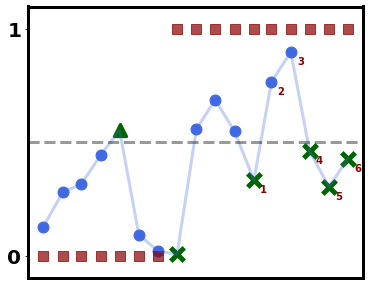

In [446]:
# def performance(X, y, data_choose, BCI_Real_monthly):
n = len(X_bm)
train_size = int(n * 0.7)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

models = {
    "Logistic Regression": LogisticRegression(C=10, max_iter=10000, random_state=42, multi_class='ovr'),
}

model_performance = {}

for name, model in models.items():
    print('Benchmark,', name)
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]

    predict_proba_train = pd.DataFrame(y_pred_proba_train)
    predict_proba_test = pd.DataFrame(y_pred_proba_test)
    predict_proba_test.index = X_test.index
    predict_proba = pd.concat([predict_proba_train, predict_proba_test], axis=0)
    predict_proba_test.index = X_test.index

    plt.figure(figsize=(6,5))

    train_test_split = len(predict_proba_train)

    # plt.hlines(y = 1.1, xmin=predict_proba_test.index[0] - pd.DateOffset(days=15), xmax=predict_proba_test.index[train_test_split] - pd.DateOffset(days=15), color='salmon', linestyle='-', linewidth=10)
    # plt.hlines(y = -0.1, xmin=predict_proba_test.index[0] - pd.DateOffset(days=15), xmax=predict_proba_test.index[train_test_split] - pd.DateOffset(days=15), color='salmon', linestyle='-', linewidth=10)
    # plt.hlines(y = 1.1, xmin=predict_proba_test.index[train_test_split]- pd.DateOffset(days=15), xmax= predict_proba_test.index[-1] + pd.DateOffset(days=15), color='royalblue', linestyle='-', linewidth=10)
    # plt.hlines(y = -0.1, xmin=predict_proba_test.index[train_test_split]- pd.DateOffset(days=15), xmax= predict_proba_test.index[-1] + pd.DateOffset(days=15), color='royalblue', linestyle='-', linewidth=10)
    plt.plot(predict_proba_test, linewidth=3, color='royalblue', alpha=0.3)
    
    BCI_test = BCI_Real_monthly.loc[X_test.index]
    start_index = int(len(predict_proba_test) * 0.7)
    for i in range(len(predict_proba_test)):
        if BCI_test['Recession'].iloc[i] == 1 and predict_proba_test.values[i] < 0.5:
            plt.scatter(predict_proba_test.index[i], predict_proba_test.values[i], color='darkgreen', marker='x', s=180, lw=5, alpha=1)
        elif BCI_test['Recession'].iloc[i] == 0 and predict_proba_test.values[i] > 0.5:
            plt.scatter(predict_proba_test.index[i], predict_proba_test.values[i], color='darkgreen', marker='^', s=150, lw=3, alpha=1)
        else:
            plt.scatter(predict_proba_test.index[i], predict_proba_test.values[i], color='royalblue', s=120, alpha=1)
        if i >= start_index:
            date_num = mdates.date2num(predict_proba_test.index[i])
            offset_x = 10
            plt.text(date_num + offset_x, predict_proba_test.values[i] - 0.02, str(i - start_index + 1), 
                    color='darkred', fontsize=10, fontweight='heavy', ha='left', va='top')

    BCI_test = BCI_Real_monthly.loc[X_test.index]

    ax = plt.gca()  # 獲取當前的Axes物件
    ax.spines['top'].set_linewidth(3)    # 上邊框
    ax.spines['right'].set_linewidth(3)  # 右邊框
    ax.spines['left'].set_linewidth(3)   # 左邊框
    ax.spines['bottom'].set_linewidth(3) # 下邊框


    plt.scatter(BCI_test['Recession'].index, BCI_test['Recession'], color='darkred', marker='s', s=100, alpha=0.7)
    plt.axhline(y=0.5, color='k', linestyle='--', linewidth=3, alpha=0.4)
    plt.ylim(-0.1, 1.1)
    plt.yticks([0, 1], fontsize=20, fontweight='bold')
    plt.xticks([])
    plt.savefig('For Keynote.png', dpi=144, transparent=True)
    plt.show()